<a href="https://colab.research.google.com/github/PoonamMagadum/Parking-Classification/blob/master/3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import regularizers
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline

In [64]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        print("test ",filename)
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]


In [65]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [66]:

def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    folders = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    for folder in folders:
      files = os.listdir(video_dir+"/"+folder)
      pbar = tqdm(total=len(files))
      for filename in files:
          pbar.update(1)
          if filename == '.DS_Store':
              continue
          name = os.path.join(video_dir+"/"+folder, filename)
          # label = vid3d.get_UCF_classname(folder)
          label = folder
          if label not in labellist:
              if len(labellist) >= nclass:
                  continue
              labellist.append(label)
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

      pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [67]:
args = EasyDict({
    "batch": 32,
    "epoch": 500,
    "videos":'/content/drive/My Drive/dataset',
    "nclass":3,
    "color":True,
    "skip":False,
    "depth":12,
    "output": '/content/drive/My Drive/Parking Videos/result3' 
})

In [68]:
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
fname_npz = args.output+'/dataset_{}_{}_{}.npz'.format(
    args.nclass, args.depth, args.skip)


vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = args.nclass
if os.path.exists(fname_npz):
    loadeddata = np.load(fname_npz)
    X, Y = loadeddata["X"], loadeddata["Y"]
else:
    x, y = loaddata(args.videos, vid3d, args.nclass,
                    args.output, args.color, args.skip)
    X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
    Y = np_utils.to_categorical(y, nb_classes)

    X = X.astype('float32')
    np.savez(fname_npz, X=X, Y=Y)
    print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))



  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:12, 15.52it/s]

test  /content/drive/My Drive/dataset/Parking/videoplayback (1).mp4
test  /content/drive/My Drive/dataset/Parking/How To- Easy Parking 90°.mp4




  2%|▏         | 3/200 [00:00<00:27,  7.17it/s]

  2%|▎         | 5/200 [00:00<00:24,  8.00it/s]

test  /content/drive/My Drive/dataset/Parking/Video 2020-06-06 at 7.29.01 PM.mp4
test  /content/drive/My Drive/dataset/Parking/Video 2020-06-06 at 7.28.51 PM.mp4
test  /content/drive/My Drive/dataset/Parking/car_parking.mp4




  3%|▎         | 6/200 [00:01<01:07,  2.88it/s]

test  /content/drive/My Drive/dataset/Parking/Forward Bay Parking Manoeuvre - 2020 UK .mp4




  4%|▎         | 7/200 [00:02<01:23,  2.30it/s]

test  /content/drive/My Drive/dataset/Parking/Practice Parallel parking.mp4




  4%|▍         | 8/200 [00:02<01:33,  2.06it/s]

test  /content/drive/My Drive/dataset/Parking/Tesla Self Parking.mp4




  4%|▍         | 9/200 [00:03<01:39,  1.91it/s]

test  /content/drive/My Drive/dataset/Parking/video (1) (1).mp4




  5%|▌         | 10/200 [00:03<01:28,  2.16it/s]

test  /content/drive/My Drive/dataset/Parking/video (1).mp4




  6%|▌         | 11/200 [00:03<01:19,  2.39it/s]

test  /content/drive/My Drive/dataset/Parking/video (5) (1).mp4




  6%|▌         | 12/200 [00:04<01:13,  2.55it/s]

test  /content/drive/My Drive/dataset/Parking/video (5).mp4




  6%|▋         | 13/200 [00:04<01:09,  2.69it/s]

test  /content/drive/My Drive/dataset/Parking/Tesla Self Parking(1).mp4




  7%|▋         | 14/200 [00:05<01:22,  2.25it/s]

test  /content/drive/My Drive/dataset/Parking/HOW TO PARK A CAR.mp4




  8%|▊         | 15/200 [00:05<01:31,  2.02it/s]

test  /content/drive/My Drive/dataset/Parking/video (3) (1).mp4




  8%|▊         | 16/200 [00:06<01:23,  2.22it/s]

test  /content/drive/My Drive/dataset/Parking/video (3).mp4




  8%|▊         | 17/200 [00:06<01:15,  2.42it/s]

test  /content/drive/My Drive/dataset/Parking/video (4) (1).mp4




  9%|▉         | 18/200 [00:06<01:12,  2.50it/s]

test  /content/drive/My Drive/dataset/Parking/video (4).mp4




 10%|▉         | 19/200 [00:07<01:12,  2.50it/s]

test  /content/drive/My Drive/dataset/Parking/video (2).mp4




 10%|█         | 20/200 [00:07<01:07,  2.65it/s]

test  /content/drive/My Drive/dataset/Parking/video (6).mp4




 10%|█         | 21/200 [00:07<01:05,  2.72it/s]

test  /content/drive/My Drive/dataset/Parking/Justice for Illegal Parking.mp4




 11%|█         | 22/200 [00:08<01:26,  2.06it/s]

test  /content/drive/My Drive/dataset/Parking/BMW X6 M Sport Parking Assist .mp4




 12%|█▏        | 23/200 [00:09<01:41,  1.74it/s]

test  /content/drive/My Drive/dataset/Parking/Parking in Japan!.mp4




 12%|█▏        | 24/200 [00:10<01:38,  1.79it/s]

test  /content/drive/My Drive/dataset/Parking/How To Park.mp4




 12%|█▎        | 25/200 [00:10<01:36,  1.81it/s]

test  /content/drive/My Drive/dataset/Parking/How To Park(1).mp4




 13%|█▎        | 26/200 [00:11<01:34,  1.84it/s]

test  /content/drive/My Drive/dataset/Parking/[ENG_-_CC]_Parking_Undur_Reverse_Parking_[Pemula](480p) (online-video-cutter.com).mp4




 14%|█▎        | 27/200 [00:11<01:18,  2.22it/s]

 14%|█▍        | 28/200 [00:11<01:03,  2.71it/s]

test  /content/drive/My Drive/dataset/Parking/[ENG_-_CC]_Parking_Undur_Reverse_Parking_[Pemula](480p) (online-video-cutter.com) (1).mp4
test  /content/drive/My Drive/dataset/Parking/[ENG_-_CC]_Parking_Undur_Reverse_Parking_[Pemula](480p) (online-video-cutter.com) (2).mp4




 14%|█▍        | 29/200 [00:11<00:53,  3.20it/s]

test  /content/drive/My Drive/dataset/Parking/90_parking_Dubai_driving_test(1080p) (online-video-cutter.com).mp4




 15%|█▌        | 30/200 [00:12<01:36,  1.77it/s]

test  /content/drive/My Drive/dataset/Parking/90_parking_Dubai_driving_test(1080p) (online-video-cutter.com) (1).mp4




 16%|█▌        | 31/200 [00:13<02:03,  1.36it/s]

test  /content/drive/My Drive/dataset/Parking/Handicapped_Parking_Karma(480p) (online-video-cutter.com).mp4




 16%|█▌        | 32/200 [00:14<01:43,  1.63it/s]

 16%|█▋        | 33/200 [00:14<01:22,  2.03it/s]

test  /content/drive/My Drive/dataset/Parking/How_to_CORRECT_REVERSE_PARKING_Toronto_Drivers(480p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/Parking/PARKING_SPOT_REVENGE(1080p) (online-video-cutter.com).mp4




 17%|█▋        | 34/200 [00:15<01:48,  1.53it/s]

 18%|█▊        | 35/200 [00:15<01:24,  1.95it/s]

test  /content/drive/My Drive/dataset/Parking/Parking_Trouble_in_Croatia-Must_See!(360p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/Parking/PlacePod_IoT_Smart_Parking_Sensor_from_PNI_Sensor_Corporation(360p) (online-video-cutter.com).mp4




 18%|█▊        | 37/200 [00:15<01:04,  2.53it/s]

test  /content/drive/My Drive/dataset/Parking/Reverse_Parking_Test_90_Degree_With_Cones_by_Mona_0559654847_UAE_Abu_dhabi(360p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/Parking/u0026_Tutorial_of_the_Reverse_Bay_Parking_Manoeuvre_for_the_UK_driving_test(480p) (online-video-cutter.com) (1).mp4




 19%|█▉        | 38/200 [00:16<01:01,  2.64it/s]

test  /content/drive/My Drive/dataset/Parking/FAPS H.264 PC-DVR CCTV Security Surveillance Camera Video of Parking Lot Overview ( 480 X 480 ).mp4




 20%|█▉        | 39/200 [00:16<00:54,  2.96it/s]

test  /content/drive/My Drive/dataset/Parking/CCTV Video of a parking lot ( 360 X 360 ).mp4
test  /content/drive/My Drive/dataset/Parking/FUNNY WOMAN DRIVER PARKING FAIL ( 480 X 480 ).mp4




 20%|██        | 41/200 [00:16<00:46,  3.45it/s]

 21%|██        | 42/200 [00:17<00:40,  3.93it/s]

test  /content/drive/My Drive/dataset/Parking/Parking Dataset ( 480 X 480 ).mp4
test  /content/drive/My Drive/dataset/Parking/Walmart Security Footage - Parking Lot (Angie Cornett) ( 360 X 320 ).mp4
test  /content/drive/My Drive/dataset/Parking/BLK-HDPTZ12 Security Camera Parkng Lot Surveillance Video ( 720 X 720 ).mp4




 22%|██▏       | 44/200 [00:17<00:45,  3.44it/s]

test  /content/drive/My Drive/dataset/Parking/bB_2nd_Gen_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video(360p) (online-video-cutter.com).mp4




 22%|██▎       | 45/200 [00:18<00:41,  3.72it/s]

test  /content/drive/My Drive/dataset/Parking/bB_2nd_Gen_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video(360p) (online-video-cutter.com) (1).mp4




 23%|██▎       | 46/200 [00:18<00:38,  3.98it/s]

test  /content/drive/My Drive/dataset/Parking/Como_pasar_el_examen_de_reversa_en_el_MVA(720p) (online-video-cutter.com).mp4




 24%|██▎       | 47/200 [00:18<00:49,  3.09it/s]

test  /content/drive/My Drive/dataset/Parking/Como_pasar_el_examen_de_reversa_en_el_MVA(720p) (online-video-cutter.com) (1).mp4




 24%|██▍       | 48/200 [00:19<00:56,  2.69it/s]

test  /content/drive/My Drive/dataset/Parking/Como_pasar_el_examen_de_reversa_en_el_MVA(720p) (online-video-cutter.com) (2).mp4




 24%|██▍       | 49/200 [00:19<01:06,  2.28it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (1).mp4




 25%|██▌       | 50/200 [00:20<00:57,  2.59it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (2).mp4




 26%|██▌       | 51/200 [00:20<00:51,  2.91it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (3).mp4




 26%|██▌       | 52/200 [00:20<00:47,  3.12it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (4).mp4




 26%|██▋       | 53/200 [00:20<00:44,  3.30it/s]

test  /content/drive/My Drive/dataset/Parking/Driving_test_at_Arfa_Tower,_Lahore_for_issuing_driving_license(1080p) (online-video-cutter.com).mp4




 27%|██▋       | 54/200 [00:22<01:39,  1.47it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (5).mp4




 28%|██▊       | 55/200 [00:22<01:20,  1.80it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (6).mp4




 28%|██▊       | 56/200 [00:22<01:05,  2.19it/s]

 28%|██▊       | 57/200 [00:23<00:53,  2.67it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (7).mp4
test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (8).mp4




 29%|██▉       | 58/200 [00:23<00:45,  3.13it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (9).mp4




 30%|██▉       | 59/200 [00:23<00:41,  3.38it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (10).mp4




 30%|███       | 60/200 [00:23<00:38,  3.65it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (11).mp4




 30%|███       | 61/200 [00:23<00:36,  3.86it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (12).mp4




 31%|███       | 62/200 [00:24<00:34,  3.95it/s]

test  /content/drive/My Drive/dataset/Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com) (13).mp4




 32%|███▏      | 63/200 [00:24<00:34,  4.02it/s]

 32%|███▏      | 64/200 [00:24<00:30,  4.39it/s]

test  /content/drive/My Drive/dataset/Parking/E46_at_School_Parking_Lot_in_Georgia,_USA(360p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/Parking/NA_Roadster_Miata_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video(360p) (online-video-cutter.com).mp4




 32%|███▎      | 65/200 [00:24<00:29,  4.51it/s]

test  /content/drive/My Drive/dataset/Parking/Japanese_Classic_Cars_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video_1(360p) (online-video-cutter.com).mp4




 33%|███▎      | 66/200 [00:25<00:29,  4.58it/s]

test  /content/drive/My Drive/dataset/Parking/Japanese_Classic_Cars_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video_1(360p) (online-video-cutter.com) (1).mp4




 34%|███▎      | 67/200 [00:25<00:29,  4.56it/s]

 34%|███▍      | 68/200 [00:25<00:27,  4.74it/s]

test  /content/drive/My Drive/dataset/Parking/SLEEPERS_GARAGE　ウチのNA8C_ロードスター最終型。(360p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/Parking/SLEEPERS_GARAGE　ウチのNA8C_ロードスター最終型。(360p) (online-video-cutter.com) (1).mp4




 34%|███▍      | 69/200 [00:25<00:28,  4.66it/s]

test  /content/drive/My Drive/dataset/Parking/SLEEPERS_GARAGE　ウチのNA8C_ロードスター最終型。(360p) (online-video-cutter.com) (2).mp4




 35%|███▌      | 70/200 [00:25<00:28,  4.64it/s]

 36%|███▌      | 71/200 [00:26<00:24,  5.28it/s]

test  /content/drive/My Drive/dataset/Parking/gettyimages-1154009934-640_adpp4.mp4
test  /content/drive/My Drive/dataset/Parking/gettyimages-1154009934-640_adpp1.mp4




 36%|███▌      | 72/200 [00:26<00:22,  5.66it/s]

 36%|███▋      | 73/200 [00:26<00:21,  5.98it/s]

test  /content/drive/My Drive/dataset/Parking/gettyimages-1154009934-640_adpp2.mp4
test  /content/drive/My Drive/dataset/Parking/gettyimages-1154009934-640_adpp3.mp4




 37%|███▋      | 74/200 [00:26<00:20,  6.01it/s]

 38%|███▊      | 75/200 [00:26<00:20,  6.13it/s]

test  /content/drive/My Drive/dataset/Parking/gettyimages-1154009934-640_adpp.mp4
test  /content/drive/My Drive/dataset/Parking/Black people sure love handicapped parking spots. (online-video-cutter.com).mp4




 38%|███▊      | 76/200 [00:27<00:35,  3.48it/s]

test  /content/drive/My Drive/dataset/Parking/Learn How To Park... On the left side of the road!! WITH GTA V!! (online-video-cutter.com).mp4




 38%|███▊      | 77/200 [00:28<00:54,  2.25it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com).mp4




 39%|███▉      | 78/200 [00:28<00:58,  2.09it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (1).mp4




 40%|███▉      | 79/200 [00:29<01:00,  2.00it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (2).mp4




 40%|████      | 80/200 [00:29<01:02,  1.92it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (3).mp4




 40%|████      | 81/200 [00:30<01:03,  1.88it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (4).mp4




 41%|████      | 82/200 [00:30<01:05,  1.80it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (5).mp4




 42%|████▏     | 83/200 [00:31<01:05,  1.80it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (6).mp4




 42%|████▏     | 84/200 [00:31<01:03,  1.83it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (7).mp4




 42%|████▎     | 85/200 [00:32<01:03,  1.81it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (8).mp4




 43%|████▎     | 86/200 [00:33<01:04,  1.78it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (9).mp4




 44%|████▎     | 87/200 [00:33<01:05,  1.73it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (10).mp4




 44%|████▍     | 88/200 [00:34<01:06,  1.69it/s]

test  /content/drive/My Drive/dataset/Parking/Daikoku Futo - Real Jdm car meet in japan (online-video-cutter.com) (11).mp4




 44%|████▍     | 89/200 [00:34<01:05,  1.70it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com).mp4




 45%|████▌     | 90/200 [00:35<01:06,  1.67it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (1).mp4




 46%|████▌     | 91/200 [00:36<01:07,  1.61it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (2).mp4




 46%|████▌     | 92/200 [00:36<01:06,  1.62it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (3).mp4




 46%|████▋     | 93/200 [00:37<01:06,  1.60it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (4).mp4




 47%|████▋     | 94/200 [00:38<01:06,  1.59it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (5).mp4




 48%|████▊     | 95/200 [00:38<01:07,  1.56it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (6).mp4




 48%|████▊     | 96/200 [00:39<01:07,  1.53it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (7).mp4




 48%|████▊     | 97/200 [00:40<01:07,  1.52it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (8).mp4




 49%|████▉     | 98/200 [00:40<01:07,  1.51it/s]

test  /content/drive/My Drive/dataset/Parking/CRAZY Midnight Hong Kong JDM Car Meet! (online-video-cutter.com) (9).mp4




 50%|████▉     | 99/200 [00:41<01:07,  1.49it/s]

test  /content/drive/My Drive/dataset/Parking/How To Make Parallel Parking In A Parking Space - Car Parking Lesson - City Car Trainers 8056256498 (online-video-cutter.com).mp4




 50%|█████     | 100/200 [00:42<01:07,  1.48it/s]

test  /content/drive/My Drive/dataset/Parking/How To Make Parallel Parking In A Parking Space - Car Parking Lesson - City Car Trainers 8056256498 (online-video-cutter.com) (1).mp4




 50%|█████     | 101/200 [00:42<01:06,  1.50it/s]

 51%|█████     | 102/200 [00:42<00:49,  1.99it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip1.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip2.mp4




 52%|█████▏    | 103/200 [00:43<00:43,  2.25it/s]

 52%|█████▏    | 104/200 [00:43<00:33,  2.90it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip3.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip4.mp4




 52%|█████▎    | 105/200 [00:43<00:27,  3.43it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip5.mp4




 53%|█████▎    | 106/200 [00:44<00:41,  2.24it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip6.mp4




 54%|█████▎    | 107/200 [00:44<00:45,  2.03it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip7.mp4




 54%|█████▍    | 108/200 [00:45<00:48,  1.90it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip8.mp4




 55%|█████▍    | 109/200 [00:46<00:49,  1.83it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip9.mp4




 55%|█████▌    | 110/200 [00:46<00:45,  1.96it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip10.mp4




 56%|█████▌    | 111/200 [00:47<00:43,  2.05it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip11.mp4




 56%|█████▌    | 112/200 [00:47<00:41,  2.12it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip12.mp4




 56%|█████▋    | 113/200 [00:47<00:39,  2.18it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip13.mp4




 57%|█████▋    | 114/200 [00:48<00:42,  2.01it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip14.mp4




 57%|█████▊    | 115/200 [00:49<00:45,  1.88it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip15.mp4




 58%|█████▊    | 116/200 [00:49<00:42,  1.99it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip16.mp4




 58%|█████▊    | 117/200 [00:49<00:39,  2.08it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip17.mp4




 59%|█████▉    | 118/200 [00:50<00:39,  2.09it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip18.mp4




 60%|█████▉    | 119/200 [00:50<00:38,  2.11it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip19.mp4




 60%|██████    | 120/200 [00:51<00:37,  2.16it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip20.mp4




 60%|██████    | 121/200 [00:51<00:36,  2.18it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip21.mp4




 61%|██████    | 122/200 [00:52<00:42,  1.85it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip22.mp4




 62%|██████▏   | 123/200 [00:53<00:45,  1.68it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip23.mp4




 62%|██████▏   | 124/200 [00:53<00:43,  1.74it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip24.mp4




 62%|██████▎   | 125/200 [00:54<00:42,  1.75it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip25.mp4




 63%|██████▎   | 126/200 [00:54<00:41,  1.80it/s]

 64%|██████▎   | 127/200 [00:54<00:32,  2.27it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip26.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip27.mp4




 64%|██████▍   | 128/200 [00:55<00:25,  2.81it/s]

 64%|██████▍   | 129/200 [00:55<00:21,  3.36it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip28.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip29.mp4




 65%|██████▌   | 130/200 [00:56<00:38,  1.83it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip30.mp4




 66%|██████▌   | 131/200 [00:57<00:48,  1.41it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip31.mp4




 66%|██████▌   | 132/200 [00:57<00:40,  1.67it/s]

 66%|██████▋   | 133/200 [00:58<00:31,  2.10it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip32.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip33.mp4




 67%|██████▋   | 134/200 [00:59<00:42,  1.55it/s]

 68%|██████▊   | 135/200 [00:59<00:32,  1.98it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip34.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip35.mp4




 68%|██████▊   | 137/200 [00:59<00:24,  2.57it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip36.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip37.mp4




 69%|██████▉   | 138/200 [00:59<00:22,  2.77it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip38.mp4




 70%|██████▉   | 139/200 [01:00<00:19,  3.13it/s]

 70%|███████   | 140/200 [01:00<00:15,  3.90it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip39.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip40.mp4




 70%|███████   | 141/200 [01:00<00:15,  3.74it/s]

 71%|███████   | 142/200 [01:00<00:13,  4.15it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip41.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip42.mp4




 72%|███████▏  | 143/200 [01:00<00:12,  4.53it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip43.mp4




 72%|███████▏  | 144/200 [01:01<00:18,  3.01it/s]



test  /content/drive/My Drive/dataset/Parking/vidclip44.mp4


 72%|███████▎  | 145/200 [01:01<00:16,  3.40it/s]

 73%|███████▎  | 146/200 [01:01<00:14,  3.74it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip45.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip46.mp4




 74%|███████▎  | 147/200 [01:02<00:17,  2.96it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip47.mp4




 74%|███████▍  | 148/200 [01:02<00:19,  2.64it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip48.mp4




 74%|███████▍  | 149/200 [01:03<00:22,  2.28it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip49.mp4




 75%|███████▌  | 150/200 [01:03<00:19,  2.62it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip50.mp4




 76%|███████▌  | 151/200 [01:03<00:16,  2.98it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip51.mp4




 76%|███████▌  | 152/200 [01:04<00:14,  3.27it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip52.mp4




 76%|███████▋  | 153/200 [01:04<00:13,  3.47it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip53.mp4




 77%|███████▋  | 154/200 [01:05<00:30,  1.50it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip54.mp4




 78%|███████▊  | 155/200 [01:06<00:24,  1.84it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip55.mp4




 78%|███████▊  | 156/200 [01:06<00:19,  2.24it/s]

 78%|███████▊  | 157/200 [01:06<00:15,  2.73it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip56.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip57.mp4




 79%|███████▉  | 158/200 [01:06<00:13,  3.19it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip58.mp4




 80%|███████▉  | 159/200 [01:06<00:11,  3.50it/s]

 80%|████████  | 160/200 [01:07<00:10,  3.85it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip59.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip60.mp4




 80%|████████  | 161/200 [01:07<00:09,  4.09it/s]

 81%|████████  | 162/200 [01:07<00:08,  4.30it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip61.mp4


test  /content/drive/My Drive/dataset/Parking/vidclip62.mp4




 82%|████████▏ | 163/200 [01:07<00:08,  4.26it/s]

 82%|████████▏ | 164/200 [01:07<00:07,  4.69it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip63.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip64.mp4




 82%|████████▎ | 165/200 [01:08<00:07,  4.71it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip65.mp4




 83%|████████▎ | 166/200 [01:08<00:07,  4.65it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip66.mp4




 84%|████████▎ | 167/200 [01:08<00:07,  4.59it/s]

 84%|████████▍ | 168/200 [01:08<00:06,  4.79it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip67.mp4
test  /content/drive/My Drive/dataset/Parking/vidclip68.mp4




 84%|████████▍ | 169/200 [01:08<00:06,  4.79it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip69.mp4




 85%|████████▌ | 170/200 [01:09<00:06,  4.72it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip70.mp4




 86%|████████▌ | 171/200 [01:09<00:06,  4.59it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip71.mp4




 86%|████████▌ | 172/200 [01:09<00:06,  4.36it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip72.mp4




 86%|████████▋ | 173/200 [01:09<00:06,  4.27it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip73.mp4




 87%|████████▋ | 174/200 [01:10<00:06,  4.19it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip74.mp4




 88%|████████▊ | 175/200 [01:10<00:06,  4.09it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip75.mp4




 88%|████████▊ | 176/200 [01:11<00:08,  2.92it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip76.mp4




 88%|████████▊ | 177/200 [01:11<00:10,  2.16it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip77.mp4




 89%|████████▉ | 178/200 [01:12<00:10,  2.04it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip78.mp4




 90%|████████▉ | 179/200 [01:12<00:10,  1.98it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip79.mp4




 90%|█████████ | 180/200 [01:13<00:10,  1.95it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip80.mp4




 90%|█████████ | 181/200 [01:13<00:10,  1.89it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip81.mp4




 91%|█████████ | 182/200 [01:14<00:09,  1.82it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip82.mp4




 92%|█████████▏| 183/200 [01:15<00:09,  1.80it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip83.mp4




 92%|█████████▏| 184/200 [01:15<00:08,  1.83it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip84.mp4




 92%|█████████▎| 185/200 [01:16<00:08,  1.81it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip85.mp4




 93%|█████████▎| 186/200 [01:16<00:07,  1.81it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip86.mp4




 94%|█████████▎| 187/200 [01:17<00:07,  1.76it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip87.mp4




 94%|█████████▍| 188/200 [01:17<00:07,  1.71it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip88.mp4




 94%|█████████▍| 189/200 [01:18<00:06,  1.73it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip89.mp4




 95%|█████████▌| 190/200 [01:19<00:05,  1.71it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip90.mp4




 96%|█████████▌| 191/200 [01:19<00:05,  1.65it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip91.mp4




 96%|█████████▌| 192/200 [01:20<00:04,  1.65it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip92.mp4




 96%|█████████▋| 193/200 [01:21<00:04,  1.64it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip93.mp4




 97%|█████████▋| 194/200 [01:21<00:03,  1.63it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip94.mp4




 98%|█████████▊| 195/200 [01:22<00:03,  1.61it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip95.mp4




 98%|█████████▊| 196/200 [01:22<00:02,  1.59it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip96.mp4




 98%|█████████▊| 197/200 [01:23<00:01,  1.58it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip97.mp4




 99%|█████████▉| 198/200 [01:24<00:01,  1.58it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip98.mp4




100%|█████████▉| 199/200 [01:24<00:00,  1.55it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip99.mp4




100%|██████████| 200/200 [01:25<00:00,  1.55it/s]

test  /content/drive/My Drive/dataset/Parking/vidclip100.mp4


100%|██████████| 200/200 [01:26<00:00,  2.32it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:19, 10.40it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-04.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-05.mp4




  2%|▏         | 3/200 [00:00<00:25,  7.74it/s]

  2%|▏         | 4/200 [00:00<00:29,  6.69it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-06.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-07.mp4




  2%|▎         | 5/200 [00:00<00:32,  6.07it/s]

  3%|▎         | 6/200 [00:00<00:33,  5.77it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-08.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-09.mp4




  4%|▎         | 7/200 [00:01<00:34,  5.54it/s]

  4%|▍         | 8/200 [00:01<00:34,  5.53it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-10.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-11.mp4




  4%|▍         | 9/200 [00:01<00:35,  5.43it/s]

  5%|▌         | 10/200 [00:01<00:34,  5.43it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-12.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-15.mp4




  6%|▌         | 11/200 [00:01<00:31,  5.97it/s]

  6%|▌         | 12/200 [00:02<00:31,  6.04it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-16.mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-13.mp4




  6%|▋         | 13/200 [00:02<00:32,  5.72it/s]

test  /content/drive/My Drive/dataset/No_Parking/VID_20200605_113022.mp4




  7%|▋         | 14/200 [00:03<01:55,  1.61it/s]

  8%|▊         | 15/200 [00:03<01:26,  2.14it/s]

test  /content/drive/My Drive/dataset/No_Parking/videoplayback (2).mp4
test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally Blocking the Emergency lane.mp4




  8%|▊         | 16/200 [00:04<01:33,  1.97it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally Blocking.mp4




  8%|▊         | 17/200 [00:05<01:40,  1.82it/s]

test  /content/drive/My Drive/dataset/No_Parking/car no parking.mp4




  9%|▉         | 18/200 [00:05<01:42,  1.78it/s]

 10%|▉         | 19/200 [00:06<01:21,  2.23it/s]

test  /content/drive/My Drive/dataset/No_Parking/repaet_VfoQ48mj_sNLk.mp4
test  /content/drive/My Drive/dataset/No_Parking/Reverse Parallel Parking Manoeuvre.mp4




 10%|█         | 20/200 [00:06<01:38,  1.82it/s]

test  /content/drive/My Drive/dataset/No_Parking/Reverse Parallel Parking Manoeuvre(1).mp4




 10%|█         | 21/200 [00:07<01:50,  1.62it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parallel Parking - Reverse Park between.mp4




 11%|█         | 22/200 [00:08<01:45,  1.68it/s]

test  /content/drive/My Drive/dataset/No_Parking/How to do Overnight Parking-Park for Overnight .mp4




 12%|█▏        | 23/200 [00:08<01:41,  1.75it/s]

test  /content/drive/My Drive/dataset/No_Parking/How To Park Downhill.mp4




 12%|█▏        | 24/200 [00:09<01:45,  1.66it/s]

 12%|█▎        | 25/200 [00:09<01:20,  2.17it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-01 (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/No_Parking/ISLab-14 (online-video-cutter.com).mp4




 13%|█▎        | 26/200 [00:09<01:09,  2.50it/s]

test  /content/drive/My Drive/dataset/No_Parking/ISLab-14 (online-video-cutter.com) (1).mp4




 14%|█▎        | 27/200 [00:10<01:05,  2.64it/s]

test  /content/drive/My Drive/dataset/No_Parking/Forgery Car Parking ( 720 X 720 ).mp4




 14%|█▍        | 28/200 [00:10<01:26,  1.99it/s]

 14%|█▍        | 29/200 [00:11<01:10,  2.43it/s]

test  /content/drive/My Drive/dataset/No_Parking/2019_Japanese_Classic_Car_Parking_Lot_Show(360p) (online-video-cutter.com).mp4
test  /content/drive/My Drive/dataset/No_Parking/Japanese_Classic_Cars_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video_1(360p) (online-video-cutter.com) (2).mp4




 15%|█▌        | 30/200 [00:11<01:02,  2.72it/s]

test  /content/drive/My Drive/dataset/No_Parking/Japanese_Classic_Cars_Stance_Nation_Nagasaki_2019_Parking_Lot_Raw_Video_1(360p) (online-video-cutter.com) (3).mp4




 16%|█▌        | 31/200 [00:11<00:55,  3.07it/s]

test  /content/drive/My Drive/dataset/No_Parking/Cops Educate Illegal Parking Violator's, Round #2 (online-video-cutter.com).mp4




 16%|█▌        | 32/200 [00:12<01:08,  2.45it/s]

test  /content/drive/My Drive/dataset/No_Parking/Cops Educate Illegal Parking Violator's, Round #2 (online-video-cutter.com) (1).mp4




 16%|█▋        | 33/200 [00:12<01:21,  2.05it/s]

test  /content/drive/My Drive/dataset/No_Parking/Cops Educate Illegal Parking Violator's, Round #2 (online-video-cutter.com) (2).mp4




 17%|█▋        | 34/200 [00:13<01:31,  1.81it/s]

test  /content/drive/My Drive/dataset/No_Parking/Cops Educate Illegal Parking Violator's, Round #2 (online-video-cutter.com) (3).mp4




 18%|█▊        | 35/200 [00:14<01:35,  1.73it/s]

test  /content/drive/My Drive/dataset/No_Parking/Cops Educate Illegal Parking Violator's, Round #2 (online-video-cutter.com) (4).mp4




 18%|█▊        | 36/200 [00:14<01:37,  1.68it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking violator is 'Special because Mamma says so' (online-video-cutter.com).mp4




 18%|█▊        | 37/200 [00:15<01:43,  1.58it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking violator is 'Special because Mamma says so' (online-video-cutter.com) (1).mp4




 19%|█▉        | 38/200 [00:16<01:41,  1.60it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal Parking Pulls Racist Card..SURPRISE ENDING (online-video-cutter.com).mp4




 20%|█▉        | 39/200 [00:16<01:44,  1.55it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal Parking Pulls Racist Card..SURPRISE ENDING (online-video-cutter.com) (1).mp4




 20%|██        | 40/200 [00:17<01:41,  1.57it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal Parking Pulls Racist Card..SURPRISE ENDING (online-video-cutter.com) (2).mp4




 20%|██        | 41/200 [00:18<01:49,  1.45it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal Parking Pulls Racist Card..SURPRISE ENDING (online-video-cutter.com) (3).mp4




 21%|██        | 42/200 [00:18<01:34,  1.67it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!! (online-video-cutter.com).mp4




 22%|██▏       | 43/200 [00:19<01:36,  1.62it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!!.mp4




 22%|██▏       | 44/200 [00:19<01:36,  1.62it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!!1.mp4




 22%|██▎       | 45/200 [00:20<01:37,  1.60it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!! (online-video-cutter.com) (3).mp4




 23%|██▎       | 46/200 [00:21<01:37,  1.58it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!! (online-video-cutter.com) (4).mp4




 24%|██▎       | 47/200 [00:21<01:39,  1.54it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!! (online-video-cutter.com) (5).mp4




 24%|██▍       | 48/200 [00:22<01:34,  1.61it/s]

test  /content/drive/My Drive/dataset/No_Parking/Angry Illegal Driver returns to the scene of the crime!! (online-video-cutter.com) (6).mp4




 24%|██▍       | 49/200 [00:23<01:34,  1.61it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com).mp4




 25%|██▌       | 50/200 [00:23<01:32,  1.63it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (1).mp4




 26%|██▌       | 51/200 [00:24<01:38,  1.52it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (2).mp4




 26%|██▌       | 52/200 [00:25<01:41,  1.46it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (3).mp4




 26%|██▋       | 53/200 [00:25<01:37,  1.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (4).mp4




 27%|██▋       | 54/200 [00:26<01:35,  1.53it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (5).mp4




 28%|██▊       | 55/200 [00:27<01:36,  1.50it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (6).mp4




 28%|██▊       | 56/200 [00:27<01:35,  1.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegally Parked Driver & an ANGRY UPS manager, Can't Get it together (online-video-cutter.com) (7).mp4




 28%|██▊       | 57/200 [00:28<01:35,  1.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com).mp4




 29%|██▉       | 58/200 [00:29<01:35,  1.49it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (1).mp4




 30%|██▉       | 59/200 [00:29<01:37,  1.45it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (2).mp4




 30%|███       | 60/200 [00:30<01:35,  1.47it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (3).mp4




 30%|███       | 61/200 [00:31<01:32,  1.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (4).mp4




 31%|███       | 62/200 [00:31<01:30,  1.53it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (5).mp4




 32%|███▏      | 63/200 [00:32<01:31,  1.49it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Im Lazy' Illegal Parking Violator OWNS IT!! (online-video-cutter.com) (6).mp4




 32%|███▏      | 64/200 [00:33<01:32,  1.46it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Mind your Business' Angry Florida Driver #2 (online-video-cutter.com).mp4




 32%|███▎      | 65/200 [00:33<01:33,  1.45it/s]

test  /content/drive/My Drive/dataset/No_Parking/'Mind your Business' Angry Florida Driver #2 (online-video-cutter.com) (1).mp4




 33%|███▎      | 66/200 [00:34<01:31,  1.46it/s]

test  /content/drive/My Drive/dataset/No_Parking/Picking up cars which are parked on no parking.. (online-video-cutter.com).mp4




 34%|███▎      | 67/200 [00:34<01:15,  1.77it/s]

test  /content/drive/My Drive/dataset/No_Parking/videoplayback (online-video-cutter.com).mp4




 34%|███▍      | 68/200 [00:35<01:01,  2.16it/s]

 34%|███▍      | 69/200 [00:35<00:49,  2.64it/s]

test  /content/drive/My Drive/dataset/No_Parking/videoplayback (online-video-cutter.com) (1).mp4
test  /content/drive/My Drive/dataset/No_Parking/videoplayback (online-video-cutter.com) (2).mp4




 35%|███▌      | 70/200 [00:35<00:42,  3.09it/s]

 36%|███▌      | 71/200 [00:35<00:37,  3.48it/s]

test  /content/drive/My Drive/dataset/No_Parking/videoplayback (online-video-cutter.com) (3).mp4
test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally, Crazy Lady Backward Driving in Tampa. (online-video-cutter.com).mp4




 36%|███▌      | 72/200 [00:36<00:52,  2.43it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally, Crazy Lady Backward Driving in Tampa. (online-video-cutter.com) (1).mp4




 36%|███▋      | 73/200 [00:37<01:04,  1.96it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally, Crazy Lady Backward Driving in Tampa. (online-video-cutter.com) (2).mp4




 37%|███▋      | 74/200 [00:37<01:14,  1.69it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally, Crazy Lady Backward Driving in Tampa. (online-video-cutter.com) (3).mp4




 38%|███▊      | 75/200 [00:38<01:15,  1.65it/s]

test  /content/drive/My Drive/dataset/No_Parking/Parked Illegally, Crazy Lady Backward Driving in Tampa. (online-video-cutter.com) (4).mp4




 38%|███▊      | 76/200 [00:39<01:20,  1.54it/s]

test  /content/drive/My Drive/dataset/No_Parking/We Tried Warning Them. Some Won't Listen. (online-video-cutter.com).mp4




 38%|███▊      | 77/200 [00:39<01:14,  1.66it/s]

test  /content/drive/My Drive/dataset/No_Parking/We Tried Warning Them. Some Won't Listen. (online-video-cutter.com) (1).mp4




 39%|███▉      | 78/200 [00:40<01:07,  1.80it/s]

test  /content/drive/My Drive/dataset/No_Parking/Drive- How to reverse parallel park (online-video-cutter.com).mp4




 40%|███▉      | 79/200 [00:40<01:04,  1.86it/s]

test  /content/drive/My Drive/dataset/No_Parking/Drive- How to reverse parallel park (online-video-cutter.com) (1).mp4




 40%|████      | 80/200 [00:41<01:08,  1.76it/s]

test  /content/drive/My Drive/dataset/No_Parking/Drive- How to reverse parallel park (online-video-cutter.com) (2).mp4




 40%|████      | 81/200 [00:41<01:09,  1.72it/s]

test  /content/drive/My Drive/dataset/No_Parking/Drive- How to reverse parallel park (online-video-cutter.com) (3).mp4




 41%|████      | 82/200 [00:42<01:07,  1.74it/s]

test  /content/drive/My Drive/dataset/No_Parking/Taiwan dangerous parking- 3-road intersection blocked by multiple illegally parked cars. (online-video-cutter.com).mp4




 42%|████▏     | 83/200 [00:43<01:05,  1.77it/s]

test  /content/drive/My Drive/dataset/No_Parking/Taiwan dangerous parking- 3-road intersection blocked by multiple illegally parked cars. (online-video-cutter.com) (1).mp4




 42%|████▏     | 84/200 [00:43<01:12,  1.60it/s]

test  /content/drive/My Drive/dataset/No_Parking/Taiwan dangerous parking- 3-road intersection blocked by multiple illegally parked cars. (online-video-cutter.com) (2).mp4




 42%|████▎     | 85/200 [00:44<01:15,  1.53it/s]

test  /content/drive/My Drive/dataset/No_Parking/Workers Move Legally Parked Car With A Forklift! (online-video-cutter.com).mp4




 43%|████▎     | 86/200 [00:45<01:12,  1.57it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking is 'ok' with emergency Lights & Customer Privileges (online-video-cutter.com).mp4




 44%|████▎     | 87/200 [00:45<01:12,  1.56it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking is 'ok' with emergency Lights & Customer Privileges (online-video-cutter.com) (1).mp4




 44%|████▍     | 88/200 [00:46<01:13,  1.52it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking is 'ok' with emergency Lights & Customer Privileges (online-video-cutter.com) (2).mp4




 44%|████▍     | 89/200 [00:47<01:15,  1.47it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking is 'ok' with emergency Lights & Customer Privileges (online-video-cutter.com) (3).mp4




 45%|████▌     | 90/200 [00:47<01:12,  1.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/Illegal parking is 'ok' with emergency Lights & Customer Privileges (online-video-cutter.com) (4).mp4




 46%|████▌     | 91/200 [00:48<01:13,  1.48it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com).mp4




 46%|████▌     | 92/200 [00:49<01:16,  1.41it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (1).mp4




 46%|████▋     | 93/200 [00:50<01:17,  1.39it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (2).mp4




 47%|████▋     | 94/200 [00:50<01:15,  1.40it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (3).mp4




 48%|████▊     | 95/200 [00:51<01:16,  1.38it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (4).mp4




 48%|████▊     | 96/200 [00:51<01:04,  1.62it/s]

 48%|████▊     | 97/200 [00:52<00:50,  2.03it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (5).mp4


test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (6).mp4




 49%|████▉     | 98/200 [00:52<00:45,  2.24it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (7).mp4




 50%|████▉     | 99/200 [00:53<00:51,  1.97it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (8).mp4




 50%|█████     | 100/200 [00:53<00:55,  1.80it/s]

test  /content/drive/My Drive/dataset/No_Parking/So many Illegal parking Idiots...So little time (online-video-cutter.com) (9).mp4




 50%|█████     | 101/200 [00:54<00:59,  1.67it/s]

 51%|█████     | 102/200 [00:54<00:46,  2.09it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid1.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid2.mp4




 52%|█████▏    | 103/200 [00:54<00:38,  2.51it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid3.mp4




 52%|█████▏    | 104/200 [00:55<00:32,  2.92it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid4.mp4




 52%|█████▎    | 105/200 [00:55<00:28,  3.31it/s]

 53%|█████▎    | 106/200 [00:55<00:25,  3.73it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid5.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid6.mp4




 54%|█████▎    | 107/200 [00:55<00:23,  4.01it/s]

 54%|█████▍    | 108/200 [00:55<00:21,  4.30it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid7.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid8.mp4




 55%|█████▍    | 109/200 [00:56<00:20,  4.53it/s]

 55%|█████▌    | 110/200 [00:56<00:19,  4.71it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid9.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid10.mp4




 56%|█████▌    | 111/200 [00:56<00:17,  5.17it/s]

 56%|█████▌    | 112/200 [00:56<00:16,  5.45it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid11.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid12.mp4




 56%|█████▋    | 113/200 [00:56<00:16,  5.29it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid13.mp4




 57%|█████▋    | 114/200 [00:57<00:40,  2.13it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid14.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid15.mp4




 58%|█████▊    | 116/200 [00:58<00:36,  2.33it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid16.mp4




 58%|█████▊    | 117/200 [00:59<00:40,  2.06it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid17.mp4




 59%|█████▉    | 118/200 [00:59<00:42,  1.93it/s]

 60%|█████▉    | 119/200 [00:59<00:33,  2.42it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid18.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid19.mp4




 60%|██████    | 120/200 [01:00<00:40,  1.96it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid20.mp4




 60%|██████    | 121/200 [01:01<00:45,  1.73it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid21.mp4




 61%|██████    | 122/200 [01:01<00:43,  1.78it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid22.mp4




 62%|██████▏   | 123/200 [01:02<00:42,  1.81it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid23.mp4




 62%|██████▏   | 124/200 [01:03<00:43,  1.76it/s]

 62%|██████▎   | 125/200 [01:03<00:32,  2.27it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid24.mp4
test  /content/drive/My Drive/dataset/No_Parking/vid25.mp4




 63%|██████▎   | 126/200 [01:03<00:28,  2.57it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid26.mp4




 64%|██████▎   | 127/200 [01:03<00:26,  2.77it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid27.mp4




 64%|██████▍   | 128/200 [01:04<00:34,  2.06it/s]

 64%|██████▍   | 129/200 [01:04<00:28,  2.50it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid28.mp4


test  /content/drive/My Drive/dataset/No_Parking/vid29.mp4




 65%|██████▌   | 130/200 [01:05<00:24,  2.83it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid30.mp4




 66%|██████▌   | 131/200 [01:05<00:21,  3.17it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid31.mp4




 66%|██████▌   | 132/200 [01:05<00:26,  2.53it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid32.mp4




 66%|██████▋   | 133/200 [01:06<00:31,  2.14it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid33.mp4




 67%|██████▋   | 134/200 [01:07<00:50,  1.30it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid34.mp4




 68%|██████▊   | 135/200 [01:09<01:04,  1.01it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid35.mp4




 68%|██████▊   | 136/200 [01:11<01:18,  1.23s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid36.mp4




 68%|██████▊   | 137/200 [01:13<01:28,  1.41s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid37.mp4




 69%|██████▉   | 138/200 [01:14<01:35,  1.54s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid38.mp4




 70%|██████▉   | 139/200 [01:16<01:37,  1.60s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid39.mp4




 70%|███████   | 140/200 [01:18<01:37,  1.63s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid40.mp4




 70%|███████   | 141/200 [01:20<01:41,  1.72s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid41.mp4




 71%|███████   | 142/200 [01:21<01:35,  1.65s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid42.mp4




 72%|███████▏  | 143/200 [01:23<01:31,  1.61s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid43.mp4




 72%|███████▏  | 144/200 [01:24<01:22,  1.48s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid44.mp4




 72%|███████▎  | 145/200 [01:25<01:21,  1.48s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid45.mp4




 73%|███████▎  | 146/200 [01:27<01:19,  1.48s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid46.mp4




 74%|███████▎  | 147/200 [01:28<01:18,  1.49s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid47.mp4




 74%|███████▍  | 148/200 [01:30<01:21,  1.57s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid48.mp4




 74%|███████▍  | 149/200 [01:32<01:21,  1.59s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid49.mp4




 75%|███████▌  | 150/200 [01:34<01:21,  1.63s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid50.mp4




 76%|███████▌  | 151/200 [01:35<01:22,  1.68s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid51.mp4




 76%|███████▌  | 152/200 [01:37<01:24,  1.76s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid52.mp4




 76%|███████▋  | 153/200 [01:39<01:18,  1.66s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid53.mp4




 77%|███████▋  | 154/200 [01:41<01:20,  1.75s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid54.mp4




 78%|███████▊  | 155/200 [01:42<01:18,  1.75s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid55.mp4




 78%|███████▊  | 156/200 [01:44<01:18,  1.79s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid56.mp4




 78%|███████▊  | 157/200 [01:46<01:13,  1.72s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid57.mp4




 79%|███████▉  | 158/200 [01:47<01:10,  1.67s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid58.mp4




 80%|███████▉  | 159/200 [01:49<01:07,  1.64s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid59.mp4




 80%|████████  | 160/200 [01:51<01:07,  1.68s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid60.mp4




 80%|████████  | 161/200 [01:52<01:05,  1.69s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid61.mp4




 81%|████████  | 162/200 [01:54<01:01,  1.61s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid62.mp4




 82%|████████▏ | 163/200 [01:56<01:01,  1.67s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid63.mp4




 82%|████████▏ | 164/200 [01:58<01:02,  1.74s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid64.mp4




 82%|████████▎ | 165/200 [01:59<00:58,  1.67s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid65.mp4




 83%|████████▎ | 166/200 [02:01<00:59,  1.74s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid66.mp4




 84%|████████▎ | 167/200 [02:02<00:47,  1.43s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid67.mp4




 84%|████████▍ | 168/200 [02:03<00:40,  1.27s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid68.mp4




 84%|████████▍ | 169/200 [02:03<00:33,  1.07s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid69.mp4




 85%|████████▌ | 170/200 [02:04<00:28,  1.07it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid70.mp4




 86%|████████▌ | 171/200 [02:05<00:27,  1.06it/s]

test  /content/drive/My Drive/dataset/No_Parking/vid71.mp4




 86%|████████▌ | 172/200 [02:07<00:34,  1.25s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid72.mp4




 86%|████████▋ | 173/200 [02:09<00:38,  1.42s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid73.mp4




 87%|████████▋ | 174/200 [02:11<00:42,  1.63s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid74.mp4




 88%|████████▊ | 175/200 [02:12<00:41,  1.66s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid75.mp4




 88%|████████▊ | 176/200 [02:14<00:41,  1.72s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid76.mp4




 88%|████████▊ | 177/200 [02:15<00:34,  1.50s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid77.mp4




 89%|████████▉ | 178/200 [02:16<00:30,  1.38s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid78.mp4




 90%|████████▉ | 179/200 [02:17<00:26,  1.24s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid79.mp4




 90%|█████████ | 180/200 [02:19<00:25,  1.26s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid80.mp4




 90%|█████████ | 181/200 [02:20<00:25,  1.32s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid81.mp4




 91%|█████████ | 182/200 [02:21<00:22,  1.23s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid82.mp4




 92%|█████████▏| 183/200 [02:22<00:21,  1.28s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid83.mp4




 92%|█████████▏| 184/200 [02:25<00:24,  1.54s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid84.mp4




 92%|█████████▎| 185/200 [02:26<00:24,  1.64s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid85.mp4




 93%|█████████▎| 186/200 [02:28<00:21,  1.52s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid86.mp4




 94%|█████████▎| 187/200 [02:31<00:27,  2.09s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid87.mp4




 94%|█████████▍| 188/200 [02:34<00:26,  2.19s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid88.mp4




 94%|█████████▍| 189/200 [02:35<00:22,  2.07s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid89.mp4




 95%|█████████▌| 190/200 [02:37<00:19,  1.96s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid90.mp4




 96%|█████████▌| 191/200 [02:38<00:15,  1.72s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid91.mp4




 96%|█████████▌| 192/200 [02:40<00:14,  1.79s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid92.mp4




 96%|█████████▋| 193/200 [02:42<00:12,  1.72s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid93.mp4




 97%|█████████▋| 194/200 [02:44<00:10,  1.77s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid94.mp4




 98%|█████████▊| 195/200 [02:46<00:09,  1.83s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid95.mp4




 98%|█████████▊| 196/200 [02:49<00:09,  2.29s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid96.mp4




 98%|█████████▊| 197/200 [02:50<00:05,  1.94s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid97.mp4




 99%|█████████▉| 198/200 [02:51<00:03,  1.58s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid98.mp4




100%|█████████▉| 199/200 [02:53<00:01,  1.67s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid99.mp4




100%|██████████| 200/200 [02:54<00:00,  1.61s/it]

test  /content/drive/My Drive/dataset/No_Parking/vid100.mp4


100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)2.mp4




  1%|          | 2/200 [00:01<02:00,  1.64it/s]

test  /content/drive/My Drive/dataset/Car Running/(HD) Exotic Car Run (Cop Trouble)-Lamborghini LP640, Rossion Q1, Superleggera and MORE (online-video-cutter.com).mp4




  2%|▏         | 3/200 [00:02<03:04,  1.07it/s]

test  /content/drive/My Drive/dataset/Car Running/(HD) Exotic Car Run (Cop Trouble)-Lamborghini LP640, Rossion Q1, Superleggera and MORE (online-video-cutter.com) (2).mp4




  2%|▏         | 4/200 [00:04<03:53,  1.19s/it]

test  /content/drive/My Drive/dataset/Car Running/(HD) Exotic Car Run (Cop Trouble)-Lamborghini LP640, Rossion Q1, Superleggera and MORE (online-video-cutter.com) (3).mp4




  2%|▎         | 5/200 [00:06<04:16,  1.32s/it]

test  /content/drive/My Drive/dataset/Car Running/(HD) Exotic Car Run (Cop Trouble)-Lamborghini LP640, Rossion Q1, Superleggera and MORE (online-video-cutter.com) (4).mp4




  3%|▎         | 6/200 [00:07<04:31,  1.40s/it]

test  /content/drive/My Drive/dataset/Car Running/Bugatti Veyron 16.4 1001 HP vs BMW M5 E34 Turbo by AG [Uncut 4k ONE TAKE] (online-video-cutter.com).mp4




  4%|▎         | 7/200 [00:09<04:34,  1.42s/it]

test  /content/drive/My Drive/dataset/Car Running/Bugatti Veyron 16.4 1001 HP vs BMW M5 E34 Turbo by AG [Uncut 4k ONE TAKE] (online-video-cutter.com) (1).mp4




  4%|▍         | 8/200 [00:11<04:45,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/Devil SRT - Ferrada Wheels - SchwaaFilms (4K) (online-video-cutter.com).mp4




  4%|▍         | 9/200 [00:12<04:47,  1.51s/it]

test  /content/drive/My Drive/dataset/Car Running/Devil SRT - Ferrada Wheels - SchwaaFilms (4K) (online-video-cutter.com) (1).mp4




  6%|▌         | 11/200 [00:14<04:17,  1.36s/it]

test  /content/drive/My Drive/dataset/Car Running/Devil SRT - Ferrada Wheels - SchwaaFilms (4K) (online-video-cutter.com) (3).mp4




  6%|▌         | 12/200 [00:16<04:19,  1.38s/it]

test  /content/drive/My Drive/dataset/Car Running/F.O.O.L - Highway (online-video-cutter.com).mp4




  6%|▋         | 13/200 [00:17<04:15,  1.37s/it]

test  /content/drive/My Drive/dataset/Car Running/F.O.O.L - Highway (online-video-cutter.com) (1).mp4




  7%|▋         | 14/200 [00:19<04:17,  1.38s/it]

test  /content/drive/My Drive/dataset/Car Running/F.O.O.L - Highway (online-video-cutter.com) (2).mp4




  8%|▊         | 15/200 [00:20<04:19,  1.40s/it]

test  /content/drive/My Drive/dataset/Car Running/F.O.O.L - Highway (online-video-cutter.com) (3).mp4




  8%|▊         | 16/200 [00:21<03:47,  1.24s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com).mp4




  8%|▊         | 17/200 [00:23<04:06,  1.35s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (1).mp4




  9%|▉         | 18/200 [00:24<04:16,  1.41s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (2).mp4




 10%|▉         | 19/200 [00:26<04:22,  1.45s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (3).mp4




 10%|█         | 20/200 [00:27<04:28,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (4).mp4




 10%|█         | 21/200 [00:29<04:23,  1.47s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (5).mp4




 11%|█         | 22/200 [00:30<04:27,  1.50s/it]

test  /content/drive/My Drive/dataset/Car Running/Kia SELTOS in Action - High Speed 140+ kmph - Chased by HEXA (online-video-cutter.com) (6).mp4




 12%|█▏        | 23/200 [00:32<04:26,  1.51s/it]

test  /content/drive/My Drive/dataset/Car Running/Mini Cooper Race Car - 1978 (online-video-cutter.com).mp4




 12%|█▏        | 24/200 [00:33<04:20,  1.48s/it]

test  /content/drive/My Drive/dataset/Car Running/Mini Cooper Race Car - 1978 (online-video-cutter.com) (1).mp4




 12%|█▎        | 25/200 [00:35<04:20,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/Mini Cooper Race Car - 1978 (online-video-cutter.com) (2).mp4




 13%|█▎        | 26/200 [00:36<04:13,  1.46s/it]

test  /content/drive/My Drive/dataset/Car Running/Ollie's 360BHP B16 Turbo Mini --) (online-video-cutter.com).mp4




 14%|█▎        | 27/200 [00:38<04:23,  1.52s/it]

test  /content/drive/My Drive/dataset/Car Running/Ollie's 360BHP B16 Turbo Mini --) (online-video-cutter.com) (1).mp4




 14%|█▍        | 28/200 [00:39<04:24,  1.54s/it]

test  /content/drive/My Drive/dataset/Car Running/Ollie's 360BHP B16 Turbo Mini --) (online-video-cutter.com) (2).mp4




 14%|█▍        | 29/200 [00:41<04:19,  1.52s/it]

test  /content/drive/My Drive/dataset/Car Running/Rich kids of MUMBAI take over Worli Sea face (INDIA)!!! (online-video-cutter.com).mp4




 15%|█▌        | 30/200 [00:42<04:13,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/Rich kids of MUMBAI take over Worli Sea face (INDIA)!!! (online-video-cutter.com) (1).mp4




 16%|█▌        | 31/200 [00:44<04:21,  1.55s/it]

test  /content/drive/My Drive/dataset/Car Running/Sasha Fierce M3 - SchwaaFilms (4K) (online-video-cutter.com).mp4




 16%|█▌        | 32/200 [00:45<04:24,  1.57s/it]

test  /content/drive/My Drive/dataset/Car Running/Sasha Fierce M3 - SchwaaFilms (4K) (online-video-cutter.com) (1).mp4




 16%|█▋        | 33/200 [00:47<04:17,  1.54s/it]

test  /content/drive/My Drive/dataset/Car Running/Sasha Fierce M3 - SchwaaFilms (4K) (online-video-cutter.com) (2).mp4




 17%|█▋        | 34/200 [00:48<04:13,  1.53s/it]

test  /content/drive/My Drive/dataset/Car Running/The all-new BMW 7 Series. Official launch film. (online-video-cutter.com).mp4




 18%|█▊        | 35/200 [00:50<04:06,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/The all-new BMW 7 Series. Official launch film. (online-video-cutter.com) (1).mp4




 18%|█▊        | 36/200 [00:51<03:41,  1.35s/it]

test  /content/drive/My Drive/dataset/Car Running/The all-new BMW 7 Series. Official launch film. (online-video-cutter.com) (2).mp4




 18%|█▊        | 37/200 [00:52<03:50,  1.42s/it]

test  /content/drive/My Drive/dataset/Car Running/The all-new BMW 7 Series. Official launch film. (online-video-cutter.com) (3).mp4




 19%|█▉        | 38/200 [00:53<03:26,  1.28s/it]

test  /content/drive/My Drive/dataset/Car Running/The all-new BMW 7 Series. Official launch film. (online-video-cutter.com) (4).mp4




 20%|█▉        | 39/200 [00:55<03:41,  1.38s/it]

test  /content/drive/My Drive/dataset/Car Running/The Best Of Street Drifting (online-video-cutter.com).mp4




 20%|██        | 40/200 [00:56<03:45,  1.41s/it]

test  /content/drive/My Drive/dataset/Car Running/The Best Of Street Drifting (online-video-cutter.com) (1).mp4




 20%|██        | 41/200 [00:58<03:46,  1.42s/it]

test  /content/drive/My Drive/dataset/Car Running/The Best Of Street Drifting (online-video-cutter.com) (2).mp4




 21%|██        | 42/200 [00:59<03:45,  1.43s/it]

test  /content/drive/My Drive/dataset/Car Running/The Best Of Street Drifting (online-video-cutter.com) (3).mp4




 22%|██▏       | 43/200 [01:01<03:52,  1.48s/it]

test  /content/drive/My Drive/dataset/Car Running/Mercedes C-Class.mp4




 22%|██▏       | 44/200 [01:03<04:04,  1.57s/it]

test  /content/drive/My Drive/dataset/Car Running/Mercedes Benz On The Road.mp4




 22%|██▎       | 45/200 [01:05<04:37,  1.79s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 2099568.mp4




 23%|██▎       | 46/200 [01:06<04:18,  1.68s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 2053100.mp4




 24%|██▎       | 47/200 [01:12<07:19,  2.87s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1572442.mp4




 24%|██▍       | 48/200 [01:15<07:33,  2.98s/it]

test  /content/drive/My Drive/dataset/Car Running/video (9).mp4




 24%|██▍       | 49/200 [01:23<11:17,  4.49s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1572547.mp4




 25%|██▌       | 50/200 [01:27<10:36,  4.25s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1572432.mp4




 26%|██▌       | 51/200 [01:30<09:49,  3.95s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 4721.mp4




 26%|██▌       | 52/200 [01:32<08:20,  3.38s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1572315.mp4




 26%|██▋       | 53/200 [01:36<08:15,  3.37s/it]

test  /content/drive/My Drive/dataset/Car Running/video (1) (1).mp4




 27%|██▋       | 54/200 [01:42<10:33,  4.34s/it]

test  /content/drive/My Drive/dataset/Car Running/Video Of New Car Model.mp4




 28%|██▊       | 55/200 [01:43<08:02,  3.33s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 2103099.mp4




 28%|██▊       | 56/200 [01:50<10:43,  4.47s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 2880.mp4




 28%|██▊       | 57/200 [01:52<08:56,  3.75s/it]

test  /content/drive/My Drive/dataset/Car Running/video (2) (1).mp4




 29%|██▉       | 58/200 [01:54<07:23,  3.12s/it]

test  /content/drive/My Drive/dataset/Car Running/video (3).mp4




 30%|██▉       | 59/200 [01:55<05:52,  2.50s/it]

test  /content/drive/My Drive/dataset/Car Running/video (4).mp4




 30%|███       | 60/200 [01:57<05:37,  2.41s/it]

test  /content/drive/My Drive/dataset/Car Running/Busy Street In New York.mp4




 30%|███       | 61/200 [01:59<05:17,  2.28s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars On Highway.mp4




 31%|███       | 62/200 [02:01<05:03,  2.20s/it]

test  /content/drive/My Drive/dataset/Car Running/video (5).mp4




 32%|███▏      | 63/200 [02:03<04:54,  2.15s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 4516.mp4




 32%|███▏      | 64/200 [02:05<04:32,  2.00s/it]

test  /content/drive/My Drive/dataset/Car Running/video (8).mp4




 32%|███▎      | 65/200 [02:07<04:18,  1.92s/it]

test  /content/drive/My Drive/dataset/Car Running/video (7).mp4




 33%|███▎      | 66/200 [02:09<04:22,  1.96s/it]

test  /content/drive/My Drive/dataset/Car Running/video (6).mp4




 34%|███▎      | 67/200 [02:18<08:59,  4.06s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip1.mp4




 34%|███▍      | 68/200 [02:19<07:03,  3.21s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip2.mp4




 34%|███▍      | 69/200 [02:20<05:39,  2.59s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip3.mp4




 35%|███▌      | 70/200 [02:22<05:09,  2.38s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip4.mp4




 36%|███▌      | 71/200 [02:24<04:52,  2.27s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip5.mp4




 36%|███▌      | 72/200 [02:26<04:42,  2.21s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip6.mp4




 36%|███▋      | 73/200 [02:28<04:33,  2.15s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip7.mp4




 37%|███▋      | 74/200 [02:30<04:19,  2.06s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip8.mp4




 38%|███▊      | 75/200 [02:32<04:04,  1.95s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip9.mp4




 38%|███▊      | 76/200 [02:34<03:57,  1.92s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip10.mp4




 38%|███▊      | 77/200 [02:35<03:56,  1.92s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip11.mp4




 39%|███▉      | 78/200 [02:37<03:32,  1.74s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip12.mp4




 40%|███▉      | 79/200 [02:38<03:16,  1.62s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip13.mp4




 40%|████      | 80/200 [02:40<03:29,  1.74s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip14.mp4




 40%|████      | 81/200 [02:42<03:18,  1.67s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip15.mp4




 41%|████      | 82/200 [02:43<03:03,  1.56s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip16.mp4




 42%|████▏     | 83/200 [02:45<03:15,  1.67s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip17.mp4




 42%|████▏     | 84/200 [02:46<03:08,  1.62s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip18.mp4




 42%|████▎     | 85/200 [02:48<03:01,  1.58s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip19.mp4




 43%|████▎     | 86/200 [02:50<03:12,  1.69s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip20.mp4




 44%|████▎     | 87/200 [02:51<02:59,  1.59s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip21.mp4




 44%|████▍     | 88/200 [02:53<02:58,  1.59s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip22.mp4




 44%|████▍     | 89/200 [02:54<02:50,  1.54s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip23.mp4




 45%|████▌     | 90/200 [02:55<02:30,  1.37s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip24.mp4




 46%|████▌     | 91/200 [02:56<02:20,  1.29s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip25.mp4




 46%|████▌     | 92/200 [02:58<02:20,  1.30s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip26.mp4




 46%|████▋     | 93/200 [02:59<02:33,  1.44s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip27.mp4




 47%|████▋     | 94/200 [03:01<02:34,  1.45s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip28.mp4




 48%|████▊     | 95/200 [03:02<02:34,  1.47s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip29.mp4




 48%|████▊     | 96/200 [03:04<02:31,  1.45s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip30.mp4




 48%|████▊     | 97/200 [03:06<02:42,  1.58s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip31.mp4




 49%|████▉     | 98/200 [03:08<02:55,  1.72s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip32.mp4




 50%|████▉     | 99/200 [03:09<02:52,  1.71s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip33.mp4




 50%|█████     | 100/200 [03:11<02:42,  1.62s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip34.mp4




 50%|█████     | 101/200 [03:12<02:20,  1.42s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip35.mp4




 51%|█████     | 102/200 [03:13<02:07,  1.30s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip36.mp4




 52%|█████▏    | 103/200 [03:14<02:12,  1.37s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip37.mp4




 52%|█████▏    | 104/200 [03:16<02:22,  1.49s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip38.mp4




 52%|█████▎    | 105/200 [03:18<02:39,  1.68s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip39.mp4




 53%|█████▎    | 106/200 [03:20<02:29,  1.59s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip40.mp4




 54%|█████▎    | 107/200 [03:22<02:38,  1.71s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip41.mp4




 54%|█████▍    | 108/200 [03:23<02:33,  1.67s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip42.mp4




 55%|█████▍    | 109/200 [03:25<02:35,  1.70s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip43.mp4




 55%|█████▌    | 110/200 [03:27<02:49,  1.88s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip44.mp4




 56%|█████▌    | 111/200 [03:30<03:10,  2.14s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip45.mp4




 56%|█████▌    | 112/200 [03:32<03:15,  2.22s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip46.mp4




 56%|█████▋    | 113/200 [03:38<04:53,  3.37s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip47.mp4




 57%|█████▋    | 114/200 [03:43<05:09,  3.60s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip48.mp4




 57%|█████▊    | 115/200 [03:51<06:58,  4.93s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip49.mp4




 58%|█████▊    | 116/200 [03:54<06:19,  4.52s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip50.mp4




 58%|█████▊    | 117/200 [03:57<05:43,  4.14s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip51.mp4




 59%|█████▉    | 118/200 [04:00<05:02,  3.68s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip52.mp4




 60%|█████▉    | 119/200 [04:03<04:45,  3.52s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip53.mp4




 60%|██████    | 120/200 [04:11<06:20,  4.76s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip54.mp4




 60%|██████    | 121/200 [04:13<05:06,  3.88s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip55.mp4




 61%|██████    | 122/200 [04:20<06:25,  4.94s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip56.mp4




 62%|██████▏   | 123/200 [04:22<05:21,  4.18s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip57.mp4




 62%|██████▏   | 124/200 [04:24<04:26,  3.51s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip58.mp4




 62%|██████▎   | 125/200 [04:26<03:36,  2.89s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip59.mp4




 63%|██████▎   | 126/200 [04:29<03:30,  2.84s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip60.mp4




 64%|██████▎   | 127/200 [04:32<03:35,  2.95s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip61.mp4




 64%|██████▍   | 128/200 [04:34<03:17,  2.75s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip62.mp4




 64%|██████▍   | 129/200 [04:37<03:13,  2.72s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip63.mp4




 65%|██████▌   | 130/200 [04:39<03:07,  2.68s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip64.mp4




 66%|██████▌   | 131/200 [04:42<03:07,  2.71s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip65.mp4




 66%|██████▌   | 132/200 [04:45<02:59,  2.64s/it]

test  /content/drive/My Drive/dataset/Car Running/vidclip66.mp4




 66%|██████▋   | 133/200 [04:55<05:39,  5.07s/it]

test  /content/drive/My Drive/dataset/Car Running/production ID_3786669.mp4




 67%|██████▋   | 134/200 [04:58<04:43,  4.29s/it]

test  /content/drive/My Drive/dataset/Car Running/production ID_4347879.mp4




 68%|██████▊   | 135/200 [05:05<05:39,  5.22s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1198818.mp4




 68%|██████▊   | 136/200 [05:07<04:32,  4.26s/it]

test  /content/drive/My Drive/dataset/Car Running/production ID_4132531.mp4




 68%|██████▊   | 137/200 [05:09<03:48,  3.63s/it]

test  /content/drive/My Drive/dataset/Car Running/video.mp4




 69%|██████▉   | 138/200 [05:11<03:12,  3.10s/it]

test  /content/drive/My Drive/dataset/Car Running/production ID_3987752.mp4




 70%|██████▉   | 139/200 [05:13<02:44,  2.70s/it]

test  /content/drive/My Drive/dataset/Car Running/video (1).mp4




 70%|███████   | 140/200 [05:15<02:25,  2.43s/it]

test  /content/drive/My Drive/dataset/Car Running/Pexels Videos 1572342.mp4




 70%|███████   | 141/200 [05:18<02:43,  2.76s/it]

test  /content/drive/My Drive/dataset/Car Running/video (2).mp4




 71%|███████   | 142/200 [05:24<03:36,  3.74s/it]

test  /content/drive/My Drive/dataset/Car Running/cut (online-video-cutter.com).mp4




 72%|███████▏  | 143/200 [05:27<03:16,  3.45s/it]

test  /content/drive/My Drive/dataset/Car Running/cut (online-video-cutter.com) (1).mp4




 72%|███████▏  | 144/200 [05:29<02:46,  2.98s/it]

test  /content/drive/My Drive/dataset/Car Running/cut (online-video-cutter.com) (2).mp4




 72%|███████▎  | 145/200 [05:31<02:22,  2.59s/it]

test  /content/drive/My Drive/dataset/Car Running/cut1 (online-video-cutter.com).mp4




 73%|███████▎  | 146/200 [05:38<03:34,  3.97s/it]

test  /content/drive/My Drive/dataset/Car Running/cut1 (online-video-cutter.com) (1).mp4




 74%|███████▎  | 147/200 [05:45<04:21,  4.93s/it]

test  /content/drive/My Drive/dataset/Car Running/cut2 (online-video-cutter.com).mp4




 74%|███████▍  | 148/200 [05:47<03:34,  4.12s/it]

test  /content/drive/My Drive/dataset/Car Running/cut2 (online-video-cutter.com) (1).mp4




 74%|███████▍  | 149/200 [05:50<03:01,  3.56s/it]

test  /content/drive/My Drive/dataset/Car Running/cut2 (online-video-cutter.com) (2).mp4




 75%|███████▌  | 150/200 [05:52<02:37,  3.15s/it]

test  /content/drive/My Drive/dataset/Car Running/cut2 (online-video-cutter.com) (3).mp4




 76%|███████▌  | 151/200 [05:54<02:19,  2.86s/it]

test  /content/drive/My Drive/dataset/Car Running/cut3 (online-video-cutter.com).mp4




 76%|███████▌  | 152/200 [05:59<02:52,  3.60s/it]

test  /content/drive/My Drive/dataset/Car Running/cut3 (online-video-cutter.com) (1).mp4




 76%|███████▋  | 153/200 [06:05<03:20,  4.26s/it]

test  /content/drive/My Drive/dataset/Car Running/cut3 (online-video-cutter.com) (2).mp4




 77%|███████▋  | 154/200 [06:10<03:31,  4.59s/it]

test  /content/drive/My Drive/dataset/Car Running/vid14.mp4




 78%|███████▊  | 155/200 [06:18<04:05,  5.44s/it]

test  /content/drive/My Drive/dataset/Car Running/vid15.mp4




 78%|███████▊  | 156/200 [06:20<03:15,  4.45s/it]

test  /content/drive/My Drive/dataset/Car Running/vid16.mp4




 78%|███████▊  | 157/200 [06:22<02:37,  3.66s/it]

test  /content/drive/My Drive/dataset/Car Running/vid17.mp4




 79%|███████▉  | 158/200 [06:24<02:17,  3.28s/it]

test  /content/drive/My Drive/dataset/Car Running/vid18.mp4




 80%|███████▉  | 159/200 [06:27<02:04,  3.02s/it]

test  /content/drive/My Drive/dataset/Car Running/vid19.mp4




 80%|████████  | 160/200 [06:32<02:28,  3.72s/it]

test  /content/drive/My Drive/dataset/Car Running/vid20.mp4




 80%|████████  | 161/200 [06:38<02:54,  4.47s/it]

test  /content/drive/My Drive/dataset/Car Running/vid21.mp4




 81%|████████  | 162/200 [06:44<03:00,  4.75s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)8.mp4




 82%|████████▏ | 163/200 [06:45<02:17,  3.72s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)7.mp4




 82%|████████▏ | 164/200 [06:46<01:47,  2.99s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)10.mp4




 82%|████████▎ | 165/200 [06:47<01:26,  2.47s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)101.mp4




 83%|████████▎ | 166/200 [06:49<01:12,  2.13s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)9.mp4




 84%|████████▎ | 167/200 [06:50<00:57,  1.74s/it]

test  /content/drive/My Drive/dataset/Car Running/2018 Infiniti QX80 Review — Cars.com.mp4




 84%|████████▍ | 168/200 [06:50<00:46,  1.44s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)4.mp4




 84%|████████▍ | 169/200 [06:51<00:38,  1.24s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)3.mp4




 85%|████████▌ | 170/200 [06:52<00:37,  1.24s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)6.mp4




 86%|████████▌ | 171/200 [06:53<00:31,  1.08s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K).mp4




 86%|████████▌ | 172/200 [06:54<00:27,  1.03it/s]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)5.mp4




 86%|████████▋ | 173/200 [06:55<00:29,  1.08s/it]

test  /content/drive/My Drive/dataset/Car Running/Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)1.mp4




 87%|████████▋ | 174/200 [06:56<00:29,  1.12s/it]

test  /content/drive/My Drive/dataset/Car Running/vid1.mp4




 88%|████████▊ | 175/200 [06:57<00:27,  1.10s/it]

test  /content/drive/My Drive/dataset/Car Running/vid2.mp4




 88%|████████▊ | 176/200 [06:59<00:28,  1.17s/it]

test  /content/drive/My Drive/dataset/Car Running/vid3.mp4




 88%|████████▊ | 177/200 [07:00<00:27,  1.20s/it]

test  /content/drive/My Drive/dataset/Car Running/vid4.mp4




 89%|████████▉ | 178/200 [07:02<00:28,  1.30s/it]

test  /content/drive/My Drive/dataset/Car Running/vid5.mp4




 90%|████████▉ | 179/200 [07:02<00:25,  1.20s/it]

test  /content/drive/My Drive/dataset/Car Running/vid6.mp4




 90%|█████████ | 180/200 [07:03<00:22,  1.11s/it]

test  /content/drive/My Drive/dataset/Car Running/vid7.mp4




 90%|█████████ | 181/200 [07:04<00:19,  1.04s/it]

test  /content/drive/My Drive/dataset/Car Running/vid8.mp4




 91%|█████████ | 182/200 [07:05<00:19,  1.08s/it]

test  /content/drive/My Drive/dataset/Car Running/vid9.mp4




 92%|█████████▏| 183/200 [07:06<00:17,  1.02s/it]

test  /content/drive/My Drive/dataset/Car Running/vid10.mp4




 92%|█████████▏| 184/200 [07:10<00:31,  1.95s/it]

test  /content/drive/My Drive/dataset/Car Running/vid11.mp4




 92%|█████████▎| 185/200 [07:13<00:30,  2.04s/it]

test  /content/drive/My Drive/dataset/Car Running/vid12.mp4




 93%|█████████▎| 186/200 [07:15<00:30,  2.21s/it]

test  /content/drive/My Drive/dataset/Car Running/vid13.mp4




 94%|█████████▎| 187/200 [07:17<00:27,  2.13s/it]

test  /content/drive/My Drive/dataset/Car Running/car_run.mp4




 94%|█████████▍| 188/200 [07:19<00:24,  2.01s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of (HD) Exotic Car Run (Cop Trouble)-Lamborghini LP640, Rossion Q1, Superleggera and MORE (online-video-cutter.com) (4).mp4




 94%|█████████▍| 189/200 [07:21<00:20,  1.91s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Cars On Highway.mp4




 95%|█████████▌| 190/200 [07:23<00:19,  1.91s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)101.mp4




 96%|█████████▌| 191/200 [07:24<00:15,  1.69s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)9.mp4




 96%|█████████▌| 192/200 [07:25<00:12,  1.53s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)7.mp4




 96%|█████████▋| 193/200 [07:26<00:09,  1.42s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Mercedes Benz On The Road (1).mp4




 97%|█████████▋| 194/200 [07:28<00:09,  1.54s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of cut (online-video-cutter.com) (1).mp4




 98%|█████████▊| 195/200 [07:30<00:07,  1.60s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of cut2 (online-video-cutter.com).mp4




 98%|█████████▊| 196/200 [07:31<00:06,  1.66s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Mercedes Benz On The Road.mp4




 98%|█████████▊| 197/200 [07:33<00:05,  1.71s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of F.O.O.L - Highway (online-video-cutter.com) (1).mp4




 99%|█████████▉| 198/200 [07:34<00:02,  1.50s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of The Best Of Street Drifting (online-video-cutter.com) (2).mp4




100%|█████████▉| 199/200 [07:36<00:01,  1.48s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of Ollie's 360BHP B16 Turbo Mini --) (online-video-cutter.com) (2).mp4




100%|██████████| 200/200 [07:37<00:00,  1.47s/it]

test  /content/drive/My Drive/dataset/Car Running/Copy of video (1).mp4


100%|██████████| 200/200 [07:44<00:00,  2.32s/it]


Saved dataset to dataset.npz.
X_shape:(600, 32, 32, 12, 3)
Y_shape:(600, 3)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 32, 32, 12, 32)    800       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 12, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 32, 32, 12, 32)    8224      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 12, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 16, 16, 6, 32)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 6, 32)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 16, 16, 6, 64)    

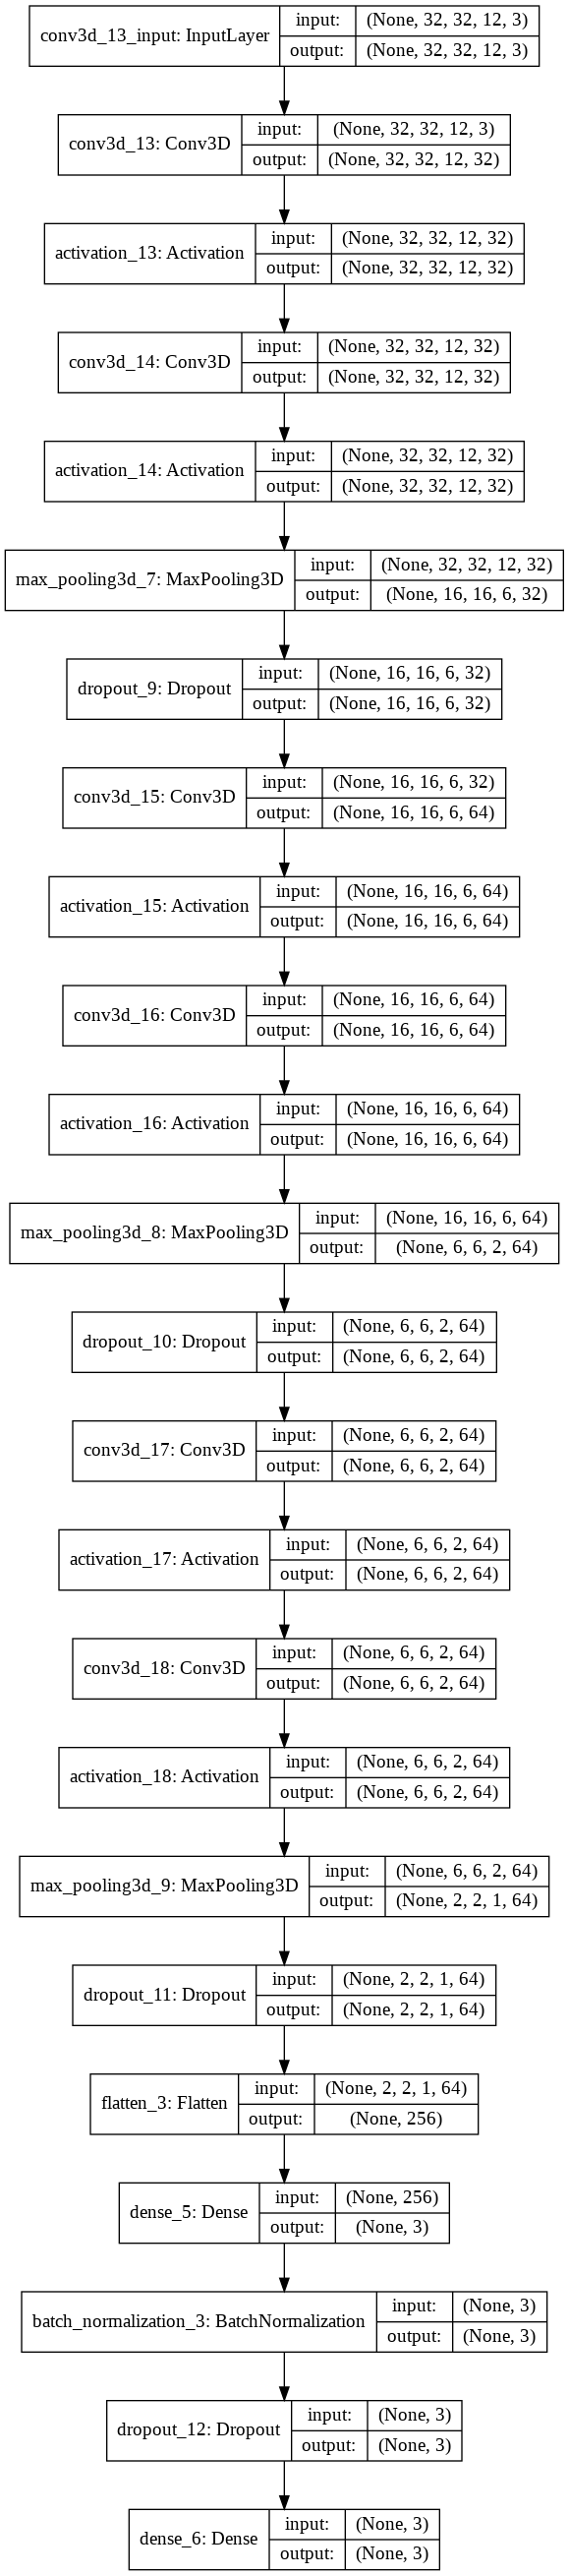

In [69]:
 # Define model
model = Sequential()
model.add(Conv3D(32, kernel_size=(2, 2, 2), input_shape=(X.shape[1:]), padding="same"))
model.add(Activation('relu'))
model.add(Conv3D(32, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True,
            to_file=os.path.join(args.output, 'model.png'))

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=43)

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=args.batch,
                    epochs=args.epoch, verbose=1, shuffle=True)

Train on 480 samples, validate on 120 samples
Epoch 1/500
480/480 [==============================] - 2s 5ms/step - loss: 1.2399 - accuracy: 0.4021 - val_loss: 12.7112 - val_accuracy: 0.4250
Epoch 2/500
480/480 [==============================] - 2s 4ms/step - loss: 1.1504 - accuracy: 0.3812 - val_loss: 7.8209 - val_accuracy: 0.4250
Epoch 3/500
480/480 [==============================] - 2s 4ms/step - loss: 1.1558 - accuracy: 0.3812 - val_loss: 3.3651 - val_accuracy: 0.4250
Epoch 4/500
480/480 [==============================] - 2s 4ms/step - loss: 1.1360 - accuracy: 0.3688 - val_loss: 1.0467 - val_accuracy: 0.4333
Epoch 5/500
480/480 [==============================] - 2s 4ms/step - loss: 1.1242 - accuracy: 0.4000 - val_loss: 1.3969 - val_accuracy: 0.4417
Epoch 6/500
480/480 [==============================] - 2s 4ms/step - loss: 1.0676 - accuracy: 0.4563 - val_loss: 1.3549 - val_accuracy: 0.4083
Epoch 7/500
480/480 [==============================] - 2s 4ms/step - loss: 1.0648 - accuracy: 0

In [71]:
model.evaluate(X_test, Y_test, verbose=0)

[0.8466851572195689, 0.8166666626930237]

In [72]:
model_json = model.to_json()
if not os.path.isdir(args.output):
    os.makedirs(args.output)
with open(os.path.join(args.output, '3dcnnmodel.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(args.output, '3dcnnmodel.hd5'))


In [73]:
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.8466851572195689
Test accuracy: 0.8166666626930237


In [74]:
save_history(history, args.output)

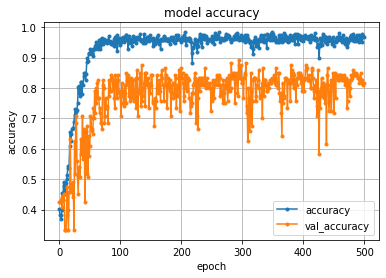

In [75]:
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(args.output, 'model_accuracy.png'))
plt.show()

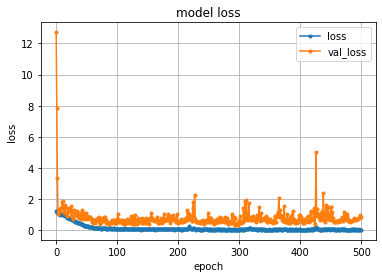

In [76]:
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(args.output, 'model_loss.png'))
plt.show()

In [94]:
# Prepare data for prediction
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
vid3d = Videoto3D(img_rows, img_cols, frames)
video='/content/drive/My Drive/Parking Videos/gettyimages-1135712026-640_adpp1.mp4'
test_data = vid3d.video3d(video, color=args.color, skip=args.skip)
t = np.expand_dims(test_data, axis=0)
print(t.shape)
td = np.array(t).transpose((0, 2, 3, 1, 4))
print(td.shape)
ls = [test_data]

test  /content/drive/My Drive/Parking Videos/gettyimages-1135712026-640_adpp1.mp4
(1, 12, 32, 32, 3)
(1, 32, 32, 12, 3)


In [95]:
from keras.models import load_model
from keras.models import model_from_json
import json
with open(os.path.join(args.output, '3dcnnmodel.json'),'r') as f:
    print(type(f))
    for i in f:
      print(type(i))
      model_json = i
      break

model = model_from_json(model_json)
model.load_weights(os.path.join(args.output, '3dcnnmodel.hd5'))

<class '_io.TextIOWrapper'>
<class 'str'>


In [96]:
# Predict.
predictions = model.predict(td)
print(predictions)

[[9.9999821e-01 1.7140914e-06 7.1565282e-08]]


In [97]:
# Process predicted result
class_names = ['Parking','No_Parking','Car running']
class_names[np.argmax(predictions)]

'Parking'

In [81]:
# Python program to write 
# text on video 
'''''
from google.colab.patches import cv2_imshow
import cv2
import cv2 
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(video) 

while(True): 
	
	# Capture frames in the video 
	ret, frame = cap.read() 

	# describe the type of font 
	# to be used. 
	font = cv2.FONT_HERSHEY_SIMPLEX 

	# Use putText() method for 
	# inserting text on video 
	cv2.putText(frame, 
				class_names[np.argmax(predictions)], 
				(50, 50), 
				font, 1, 
				(0, 255, 255), 
				2, 
				cv2.LINE_4) 

	# Display the resulting frame 
	cv2_imshow(frame) 

	# creating 'q' as the quit 
	# button for the video 
	if cv2.waitKey(1) & 0xFF == ord('q'): 
		break

# release the cap object 
cap.release() 
# close all windows 
cv2.destroyAllWindows() 
'''''

"''\nfrom google.colab.patches import cv2_imshow\nimport cv2\nimport cv2 \nimport matplotlib.pyplot as plt\n\ncap = cv2.VideoCapture(video) \n\nwhile(True): \n\t\n\t# Capture frames in the video \n\tret, frame = cap.read() \n\n\t# describe the type of font \n\t# to be used. \n\tfont = cv2.FONT_HERSHEY_SIMPLEX \n\n\t# Use putText() method for \n\t# inserting text on video \n\tcv2.putText(frame, \n\t\t\t\tclass_names[np.argmax(predictions)], \n\t\t\t\t(50, 50), \n\t\t\t\tfont, 1, \n\t\t\t\t(0, 255, 255), \n\t\t\t\t2, \n\t\t\t\tcv2.LINE_4) \n\n\t# Display the resulting frame \n\tcv2_imshow(frame) \n\n\t# creating 'q' as the quit \n\t# button for the video \n\tif cv2.waitKey(1) & 0xFF == ord('q'): \n\t\tbreak\n\n# release the cap object \ncap.release() \n# close all windows \ncv2.destroyAllWindows() \n"